In [76]:
from qiskit.quantum_info import Statevector
from qiskit.visualization.bloch import Bloch
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from sympy.physics.quantum import pauli
from numpy import pi
import numpy as np


In [77]:
Aer.backends()
simulator = Aer.get_backend('aer_simulator')
qreg_q = QuantumRegister(1, 'q')
circuit = QuantumCircuit(qreg_q)
clreg = ClassicalRegister(1)
sx = pauli.SigmaX()
sy = pauli.SigmaY()
sz = pauli.SigmaZ()

In [78]:
def to_spherical(vec):
    x = np.real(vec[0])
    y = np.real(vec[1])
    z = np.real(vec[2])
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    θ = np.arctan2(z, hxy) #el
    ϕ = np.arctan2(y, x) #az
    return [r, θ, ϕ]

def to_cartesian(polar):
    r = polar[0]
    θ = polar[1]
    ϕ = polar[2]
    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [np.real(x), np.real(y), np.real(z)]

Use of Operator-class: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html#Operator-Class

In [79]:
# Matrix taken from
# https://docplayer.org/117986458-Die-symmetriegruppen-so-3-und-su-2.html (p. 11, equation 46)
# https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf (p. 8, equation 50)

def rn_su2(theta, n):
    #todo: check magnitude must be 1
    n1 = n[0]
    n2 = n[1]
    n3 = n[2]

    return Operator([
        [np.cos(theta/2) - 1j*n3*np.sin(theta/2), -1j*(n1 - 1j*n2)*np.sin(theta/2)],
        [-1j*(n1 + 1j*n2)*np.sin(theta/2), np.cos(theta/2) + 1j*n3*np.sin(theta/2)]
    ], input_dims=(2, 1), output_dims=(2, 1))

# Magnitude of the vector n must be 1
n = [0, 0, 1]
#n = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]

# Debug: check if the matrix is unitary
mat = np.array(rn_su2(pi, n))
# Compute A^dagger.A and see if it is identity matrix
mat = np.conj(mat.T).dot(mat)
print(mat)

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


[1.0, 0.0, 0.0]
[1.0, 1.5707963267948966, 0.0]
[1.312120630447549, 0.15988587155660067, 0.0]


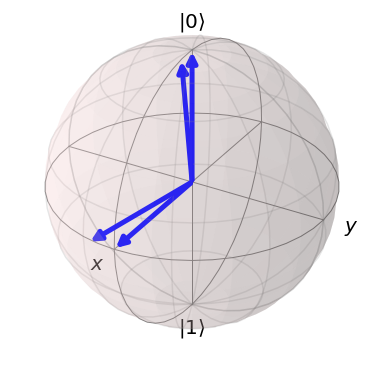

In [80]:
# construc the operator
rot_cnt = 3
rot_angle = pi/rot_cnt
n = [1, 0, 0]
rot_operator = rn_su2(rot_angle, n)
rot_matrix = np.array(rot_operator)
#circuit_rn_su2 = circuit.unitary(rot_operator, 0)

start_vec = [1, 0, 0]

_bloch = Bloch()
_bloch.vector_color = ['blue'] * rot_cnt

sv = []
vec = start_vec
sv.append(vec)
for i in range(0, rot_cnt):
    polar_vec = to_spherical(vec)
    print(polar_vec)
    polar_vec_angles = polar_vec[1:3]
    rotated_polar_vec_angles = np.array(polar_vec_angles).dot(rot_matrix)
    vec = to_cartesian(np.insert(rotated_polar_vec_angles, 0, 1, axis=0))
    sv.append(vec)

_bloch.add_vectors(sv)
_bloch.render()
#_bloch.fig